In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist 

def draw_custom_dendrogram(merge_history, labels):

    n = len(labels)
    current_idx = n
    positions = {i: i for i in range(n)}
    heights = {}

    fig, ax = plt.subplots(figsize=(10, 5))

    for c1, c2, dist, size in merge_history:
        x1 = positions[c1]
        x2 = positions[c2]
        y = dist

        ax.plot([x1, x1], [heights.get(c1, 0), y], c="black")
        ax.plot([x2, x2], [heights.get(c2, 0), y], c="black")
        ax.plot([x1, x2], [y, y], c="black")

        positions[current_idx] = (x1 + x2) / 2
        heights[current_idx] = y
        current_idx += 1

    ax.set_title("Custom Dendrogram")
    ax.set_xlabel("Sample index (approx.)")
    ax.set_ylabel("Distance")
    plt.show()

def hierarchical_clustering(data, num_clusters=None, min_distance=None):
    clusters = {i: [i] for i in range(len(data))}
    centroids = {i: data[i] for i in range(len(data))}
    merge_history = []
    cluster_sizes = {i: 1 for i in range(len(data))}

    while True:
        if num_clusters is not None and len(clusters) <= num_clusters:
            break
        min_dist = float("inf")
        to_merge = None
        
        cluster_keys = list(clusters.keys())
        for i in range(len(cluster_keys)):
            for j in range(i + 1, len(cluster_keys)):
                c1, c2 = cluster_keys[i], cluster_keys[j]
                dist = np.linalg.norm(centroids[c1] - centroids[c2])
                if dist < min_dist:
                    min_dist = dist
                    to_merge = (c1, c2)

        if to_merge is None:
            break

        if min_distance is not None and min_dist > min_distance:
            break

        c1, c2 = to_merge
        new_cluster = clusters[c1] + clusters[c2]
        new_centroid = np.mean([data[i] for i in new_cluster], axis=0)

        # Aktualizace clusterů
        new_key = max(clusters.keys()) + 1
        clusters[new_key] = new_cluster
        centroids[new_key] = new_centroid

        merge_history.append((c1, c2, min_dist, len(new_cluster)))
        cluster_sizes[max(clusters.keys()) + 1] = len(new_cluster)

        del clusters[c1]
        del clusters[c2]
        del centroids[c1]
        del centroids[c2]

    labels = np.zeros(len(data), dtype=int)
    for cluster_idx, cluster_points in enumerate(clusters.values()):
        for point in cluster_points:
            labels[point] = cluster_idx

    return labels, merge_history

def run(dataset, num_clusters, step):
    df = pd.read_csv(dataset)

    unique_generations = sorted(df["generation"].unique())

    selected_generations = [unique_generations[0]] + unique_generations[step-1::step] + [unique_generations[-1]]

    first_gen_data = df[df["generation"] == unique_generations[0]].drop(columns=["generation", "id"]).values
    pca = PCA(n_components=2)
    pca.fit(first_gen_data)

    for gen in selected_generations:
        pop_data = df[df["generation"] == gen].drop(columns=["generation", "id"]).values
        reduced_data = pca.transform(pop_data)

        pairwise_distances = cdist(pop_data, pop_data)
        max_distance = np.max(pairwise_distances)
        min_dist_threshold = 0.1 * max_distance


        clusters, merge_history = hierarchical_clustering(pop_data, min_distance=min_dist_threshold)
        

        plt.figure(figsize=(6, 6))
        #scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        plt.title(f"Generation {gen} - Custom Hierarchical Clustering")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.show()
        

        #TODO: Nutno upravit a udělat custom jelikož to vůbec nesedí k vytvořeným clusterům
        #linkage_matrix = linkage(reduced_data, method='ward')
        linkage_matrix = linkage(pop_data, method='ward')
        plt.figure(figsize=(8, 5))
        #dendrogram(linkage_matrix, truncate_mode="level", p=5)  # Zkrácení na 5 úrovní pro lepší čitelnost
        dendrogram(linkage_matrix, labels=df[df["generation"] == gen]["id"].values)
        plt.title(f"Generation {gen} - Dendrogram")
        plt.xlabel("Sample index")
        plt.ylabel("Distance")
        plt.show()

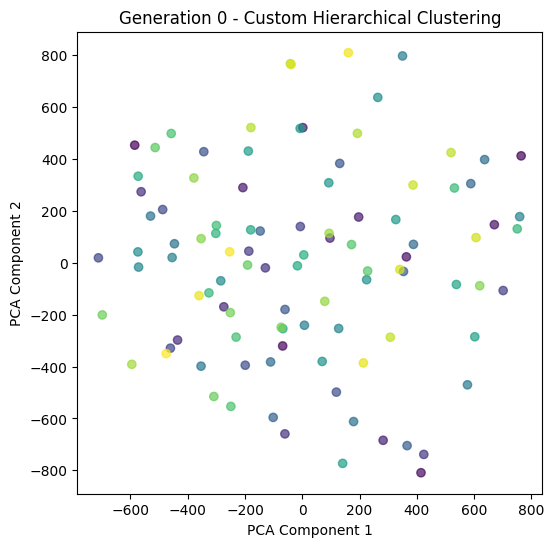

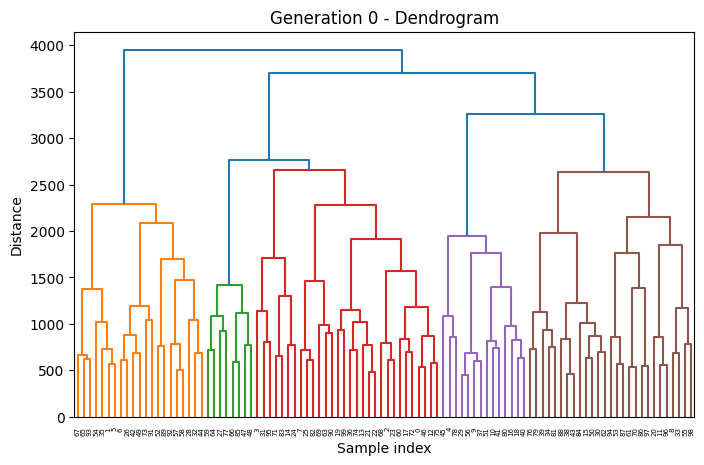

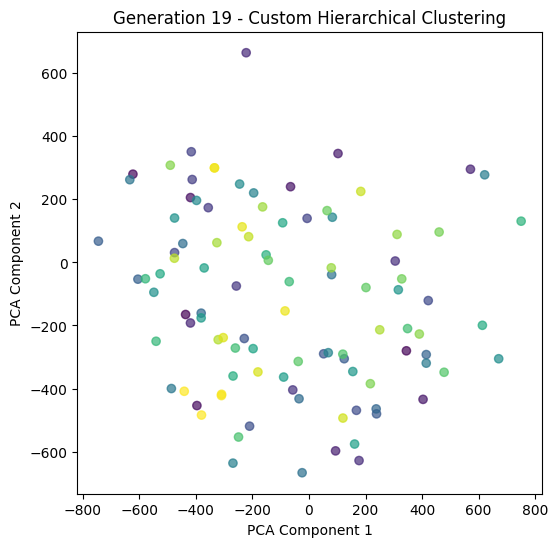

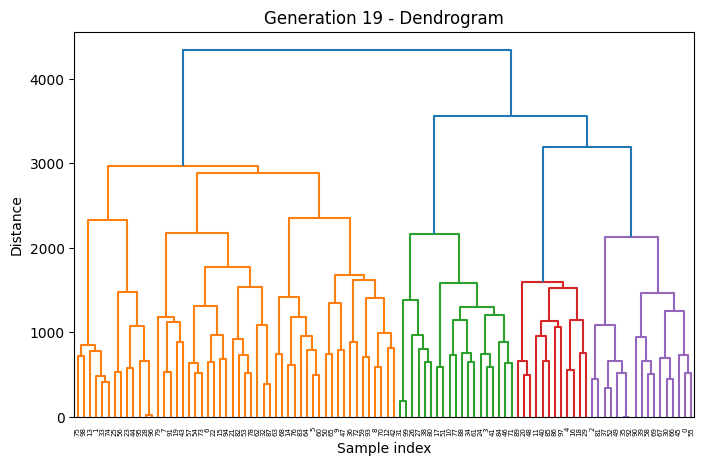

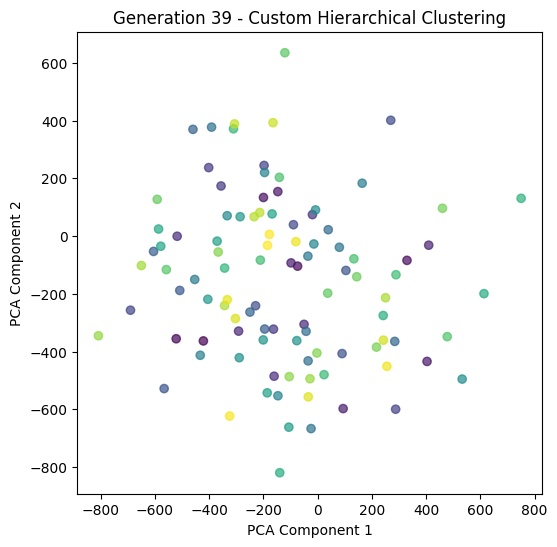

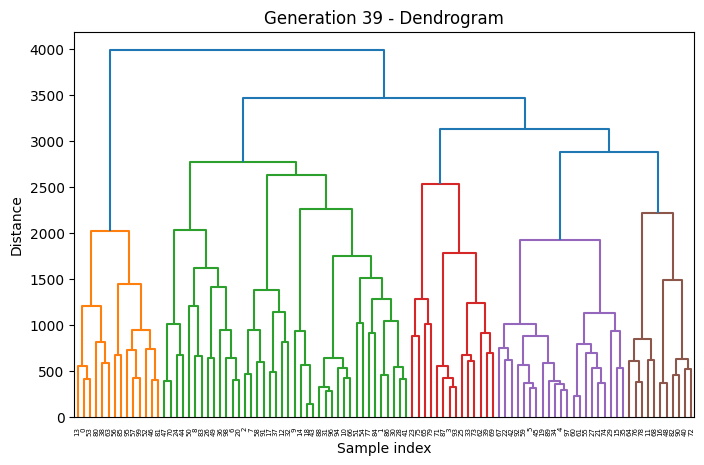

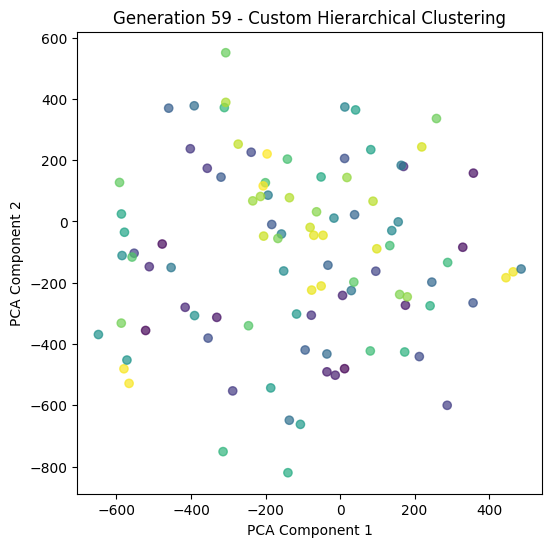

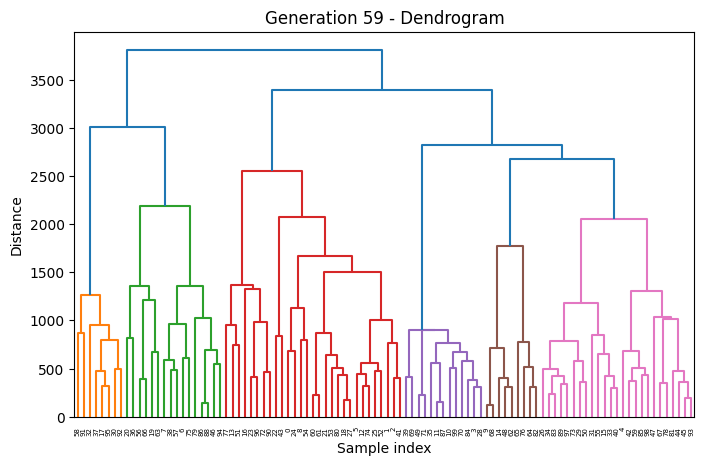

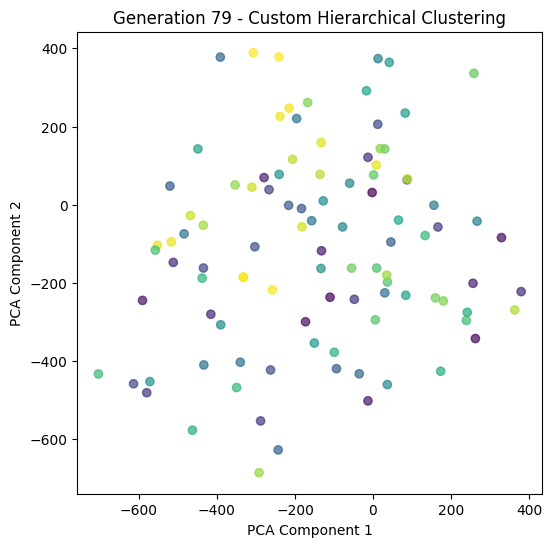

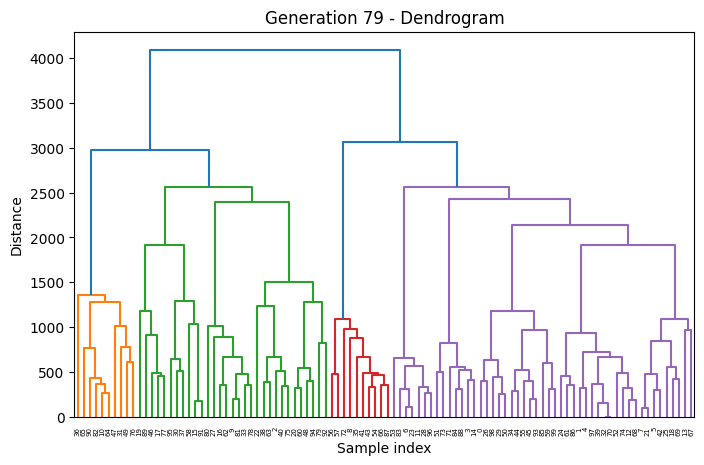

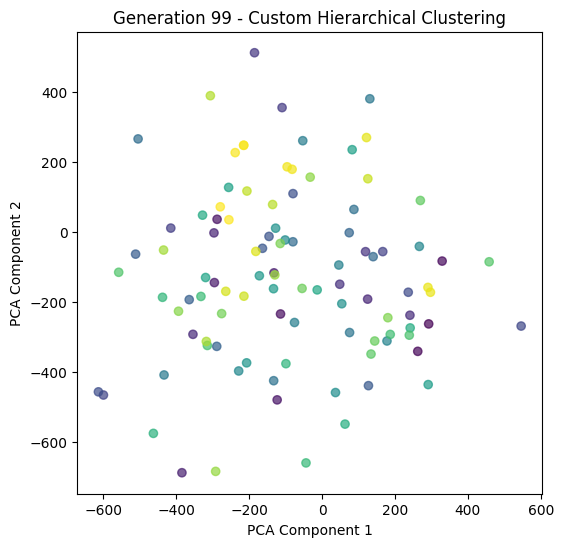

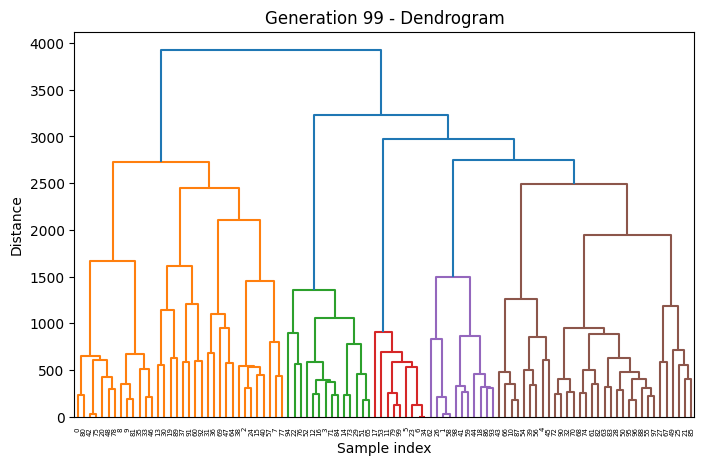

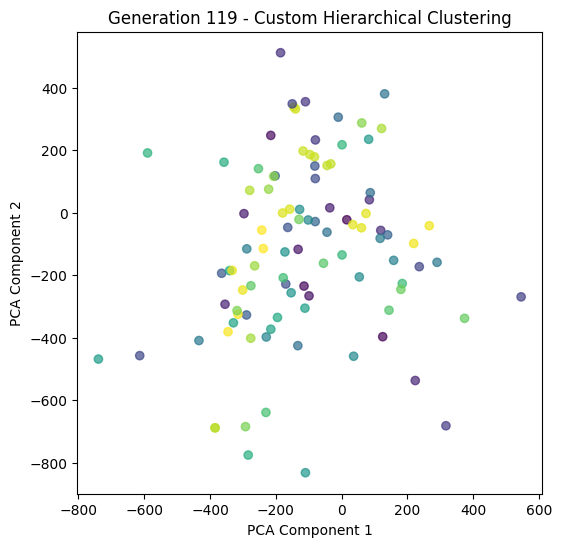

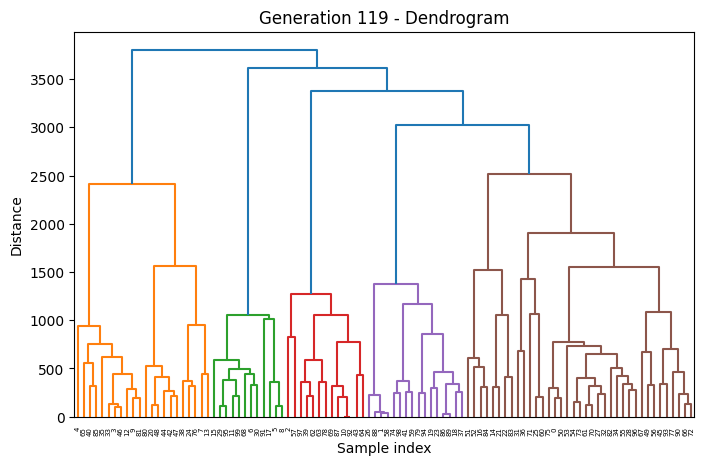

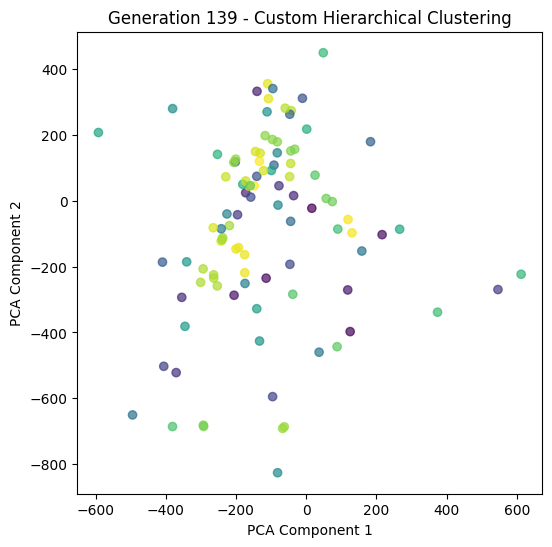

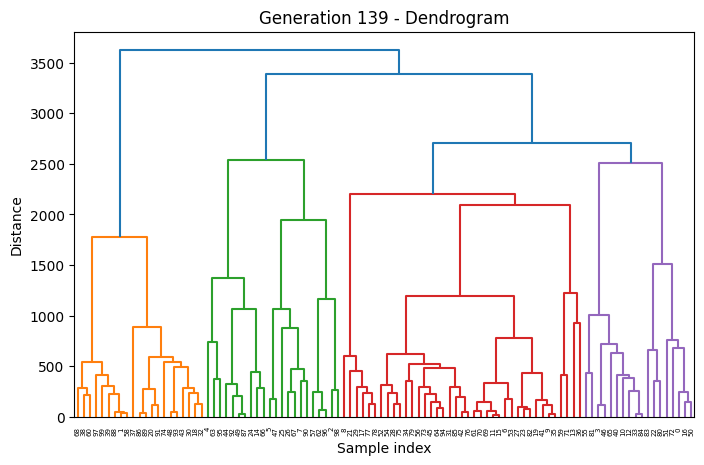

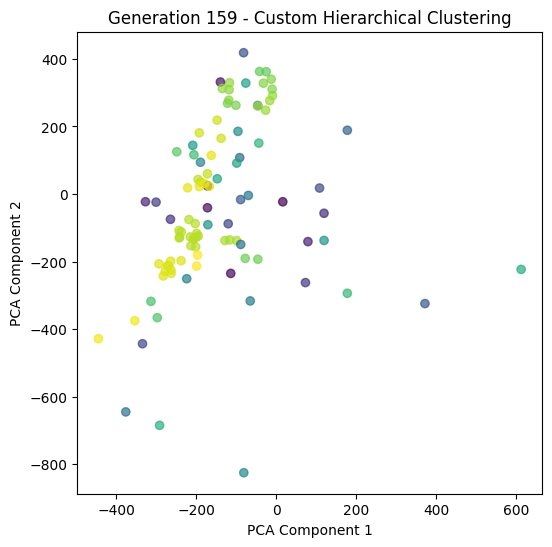

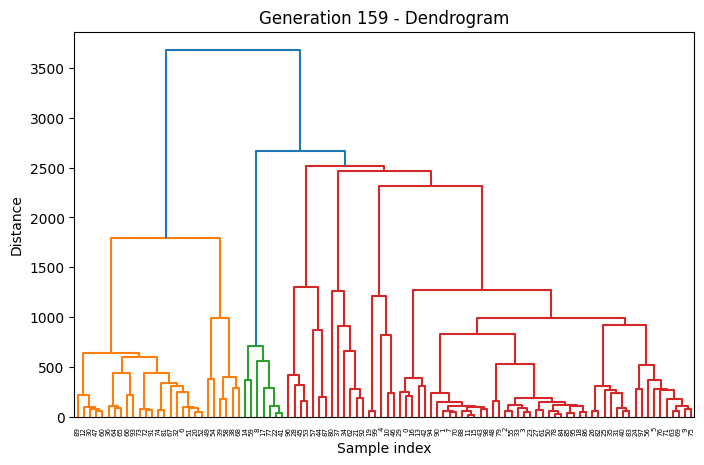

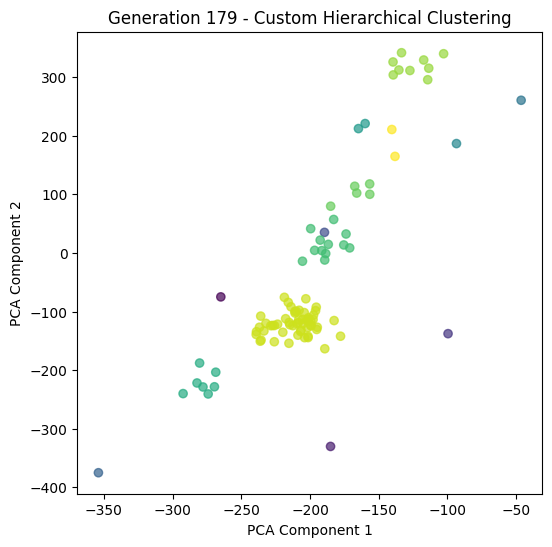

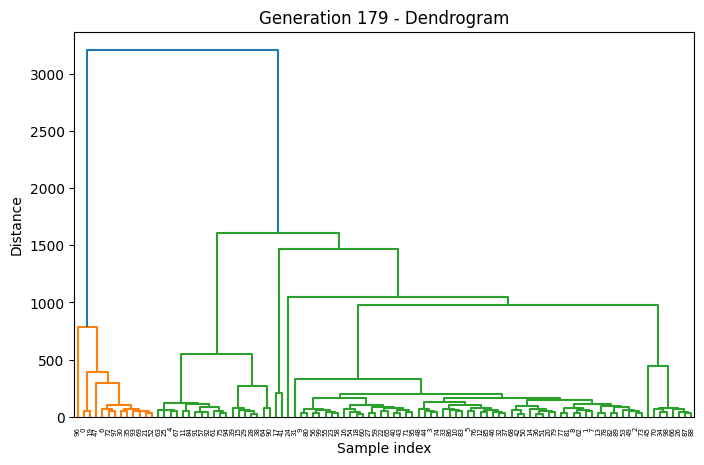

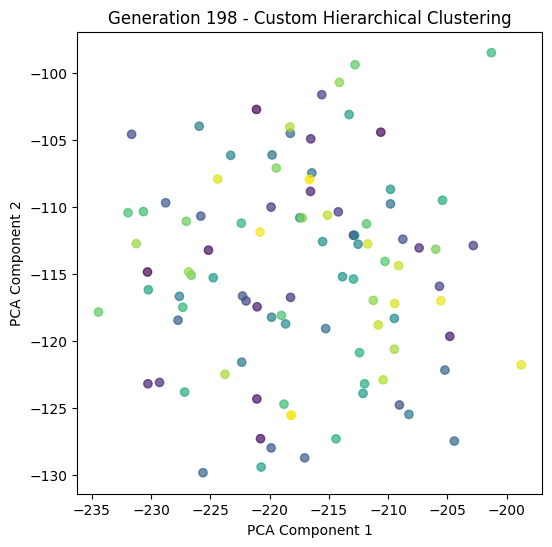

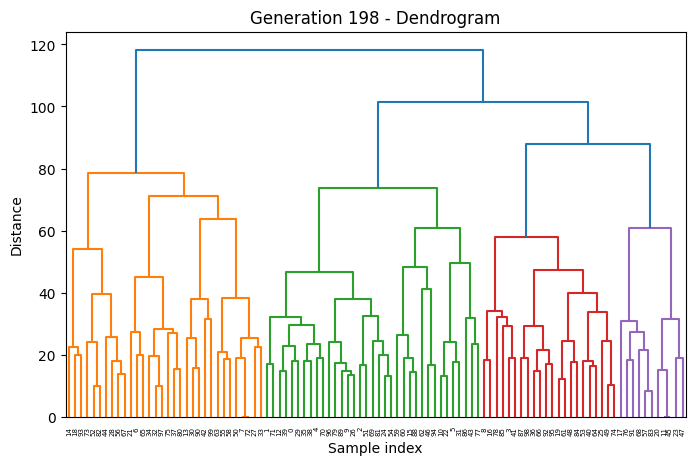

In [18]:
run("population_log_DE.csv", 3, 20)

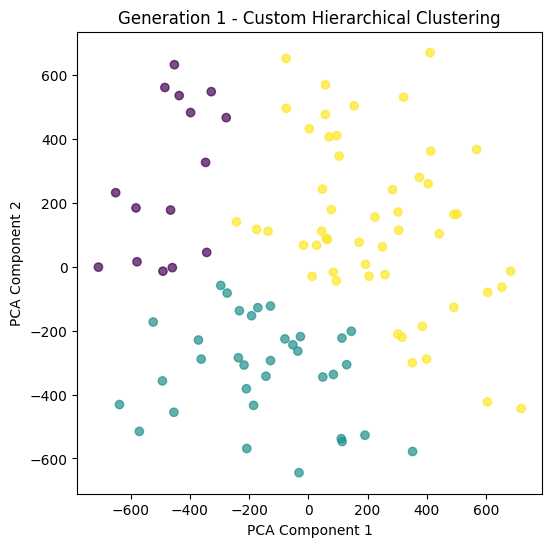

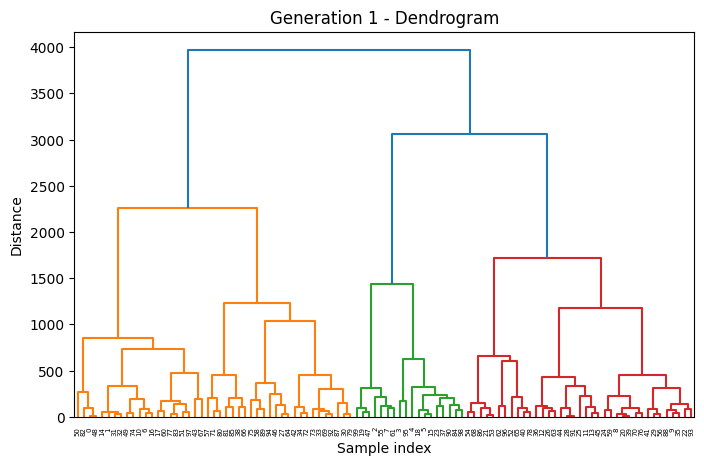

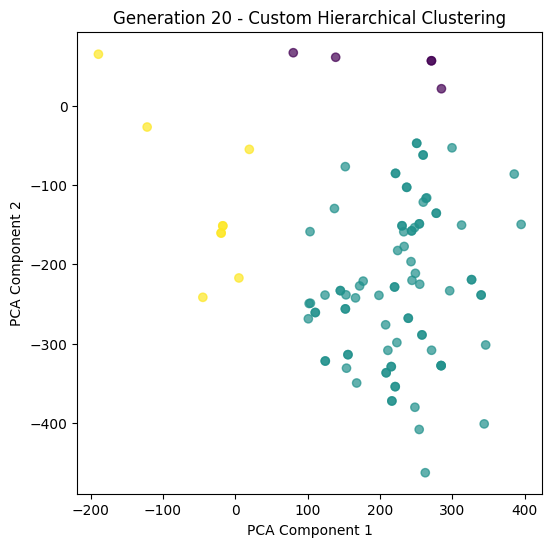

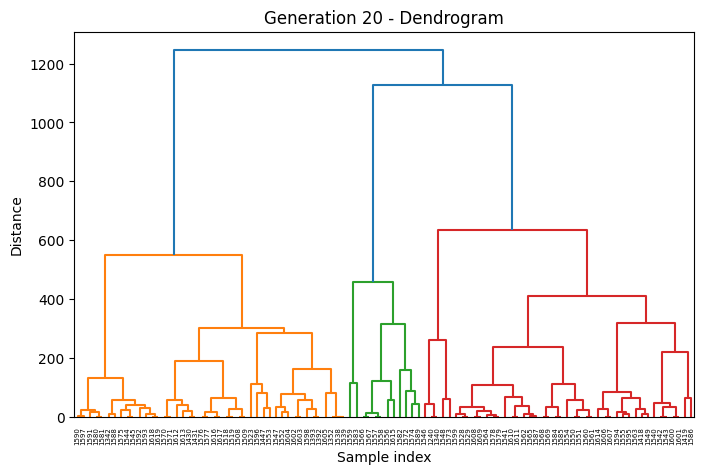

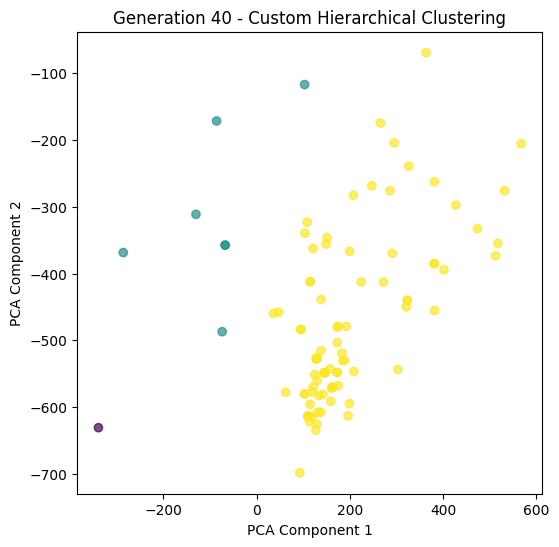

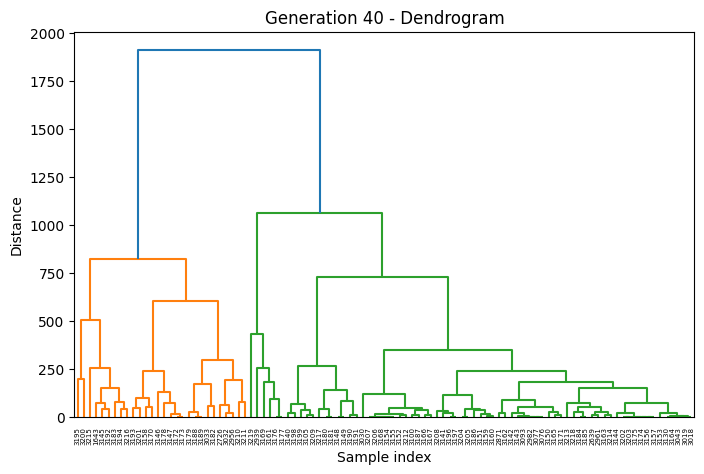

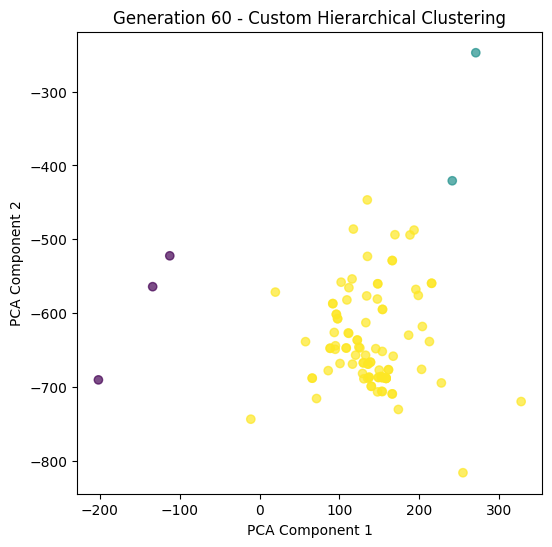

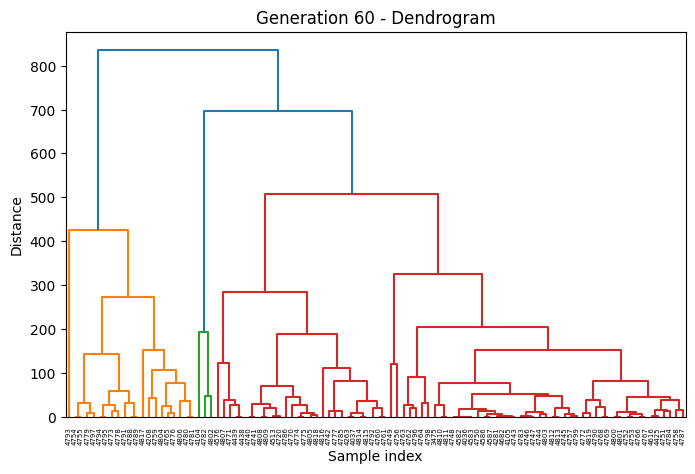

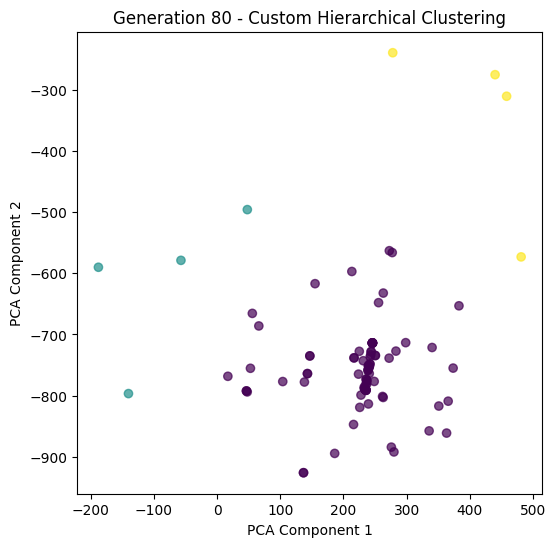

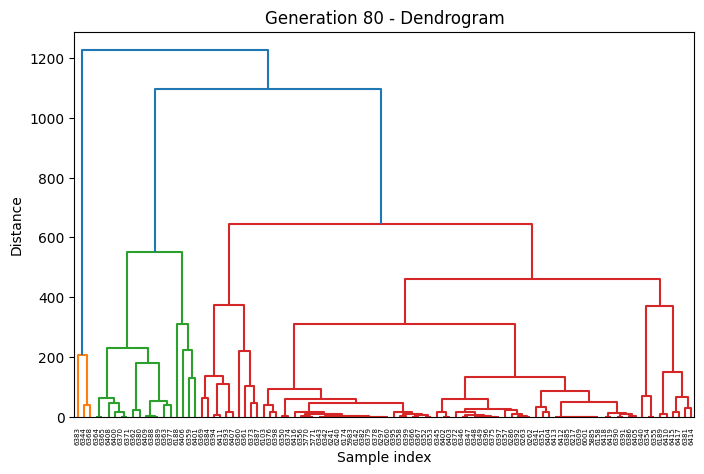

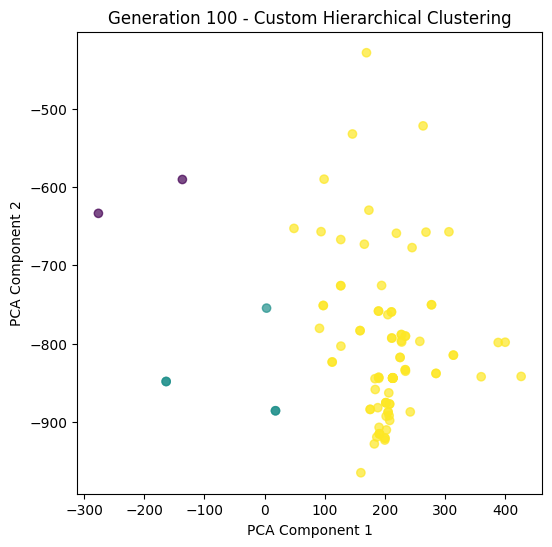

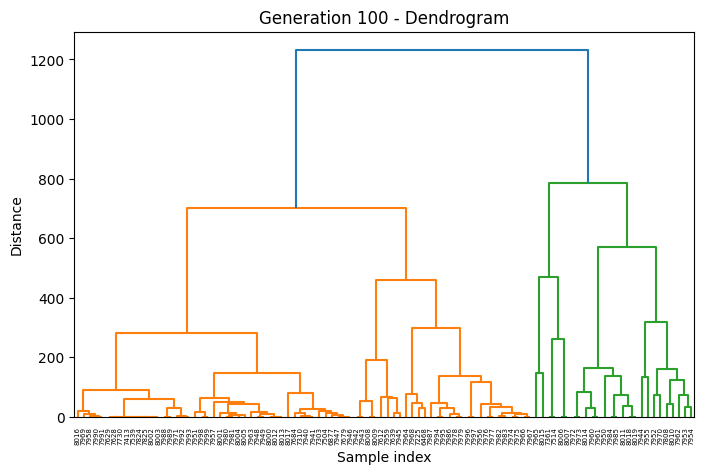

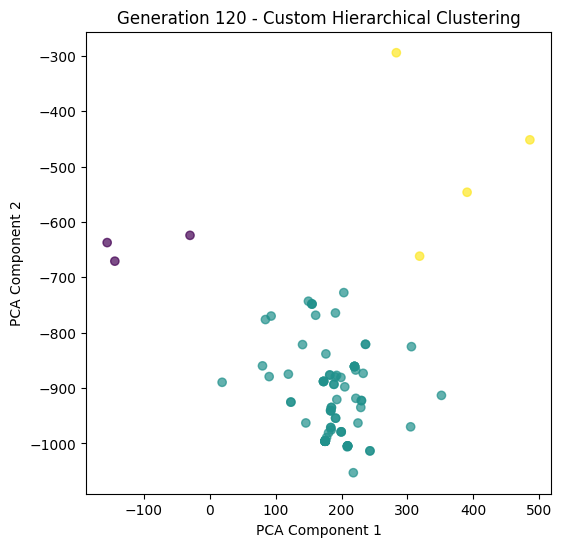

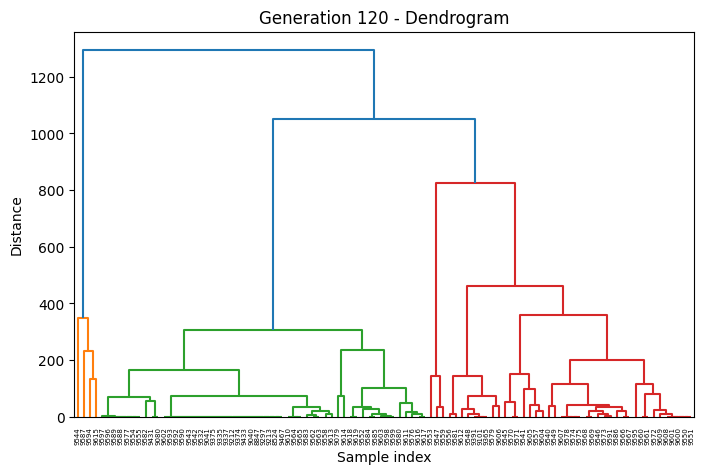

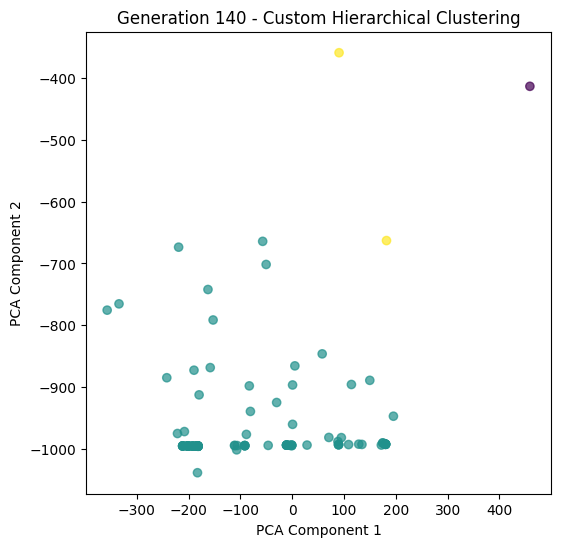

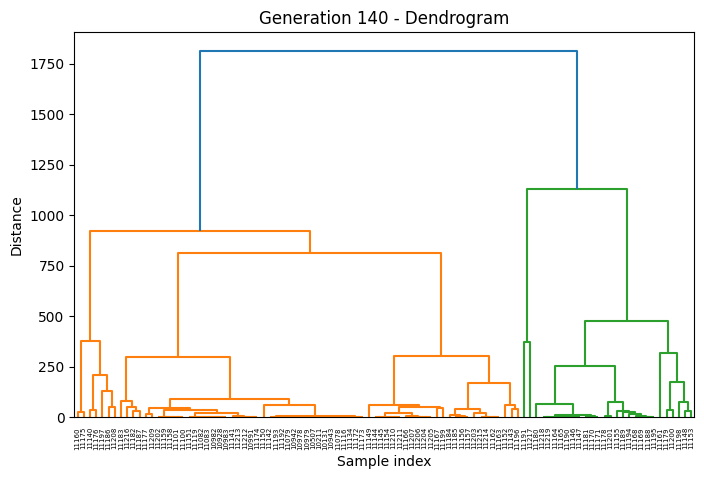

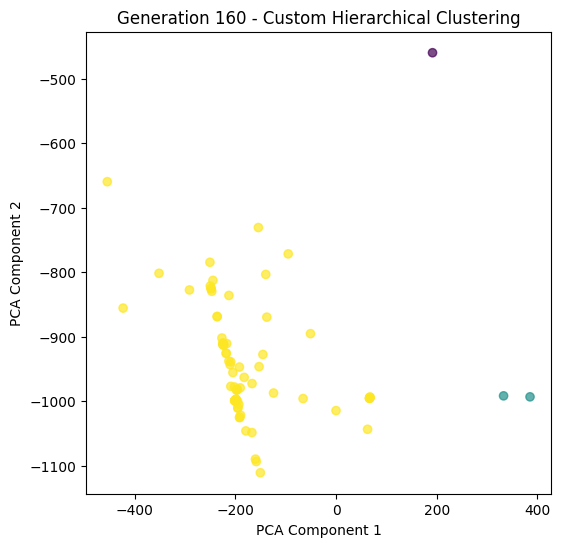

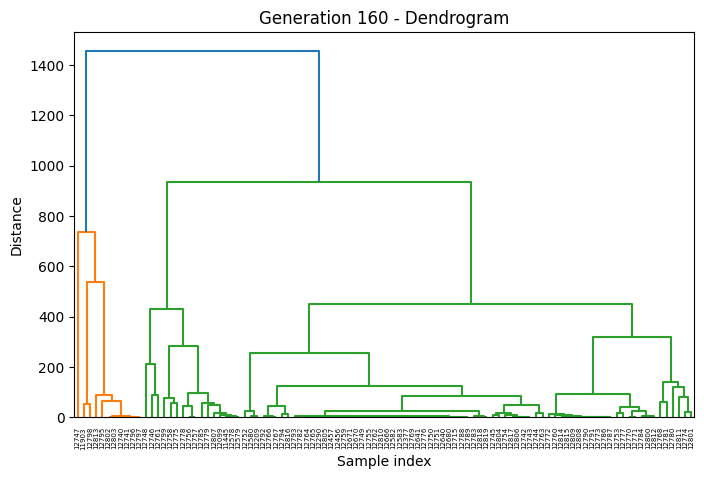

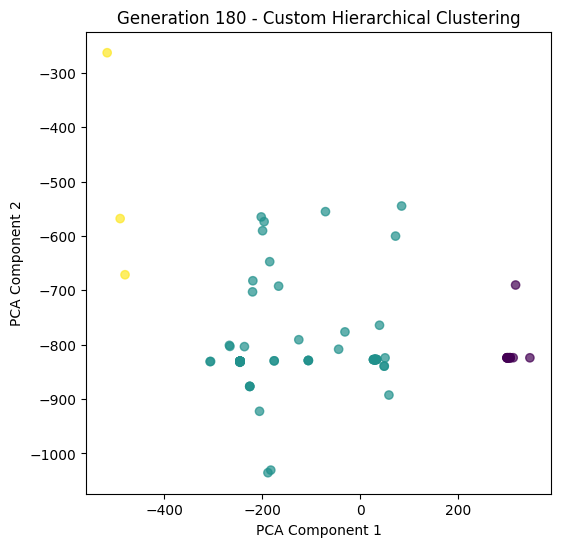

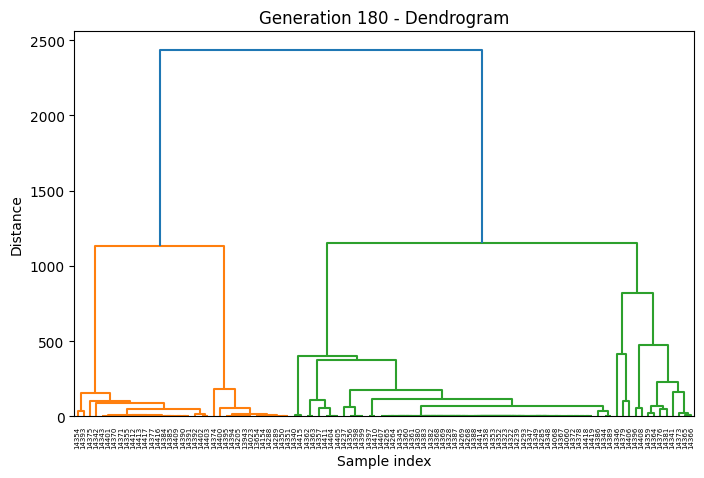

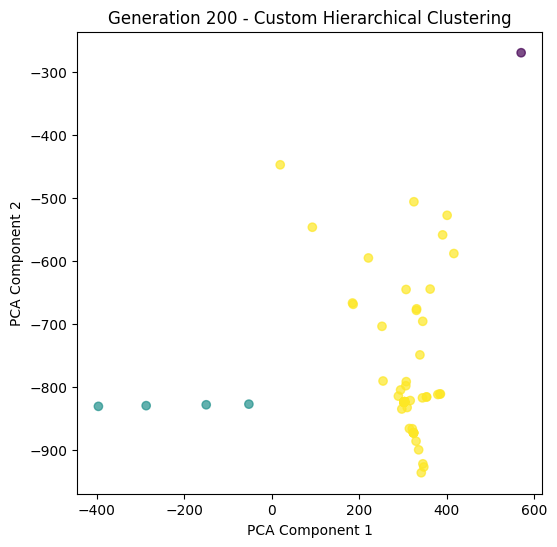

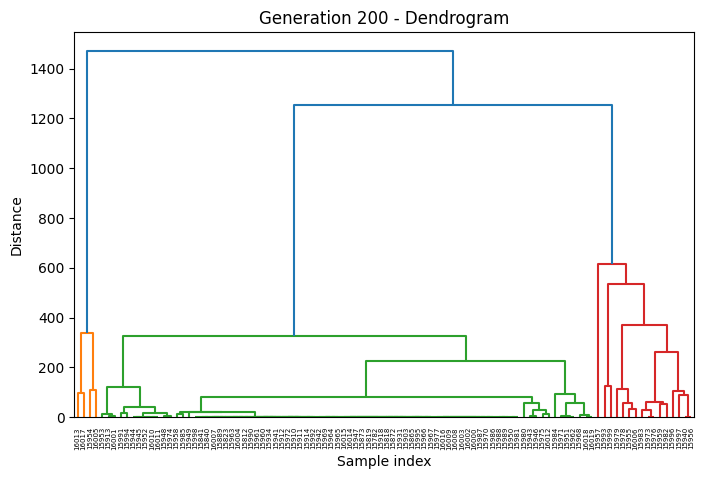

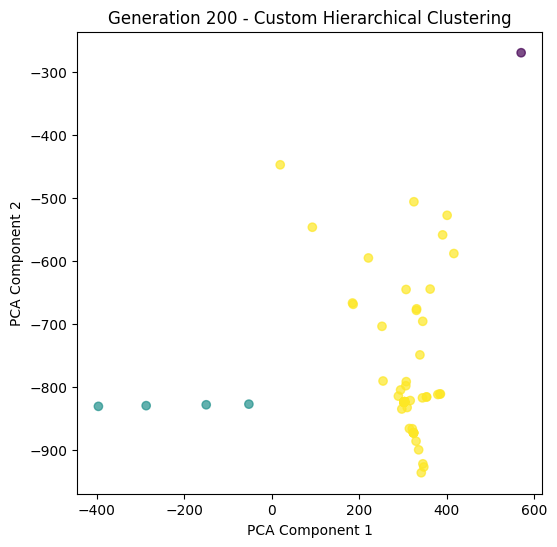

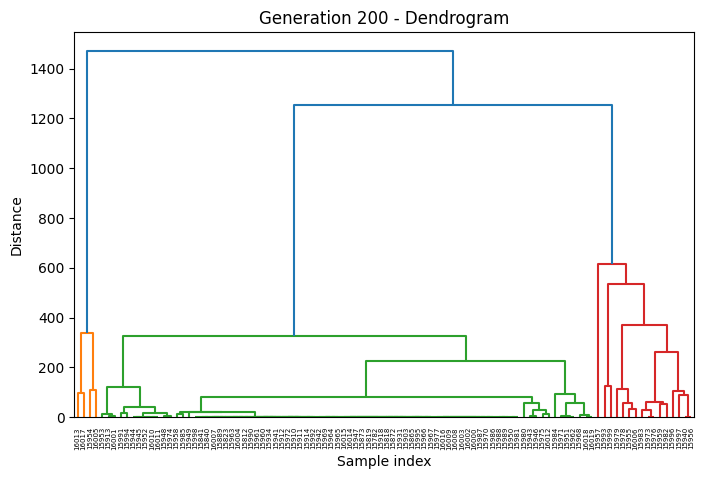

In [3]:
run("population_log_GA.csv", 3, 20)